In [1]:
import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm

In [2]:
class Robot(IdealRobot): ###add_stuck### noise, biasメソッドは省略で
        
    def __init__(self, pose, agent=None, sensor=None, color="black", \
                           noise_per_meter=5, noise_std=math.pi/60,\
                           bias_rate_stds=(0.1,0.1),\
                           expected_stuck_time = 1e100, expected_escape_time = 1e-100):  #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time)  #以下追加
        self.escape_pdf = expon(scale=expected_escape_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
    
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= nu*time_interval + self.r*omega*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval): #追加
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval) #追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        if self.sensor: self.sensor.data(self.pose)

<IPython.core.display.Javascript object>


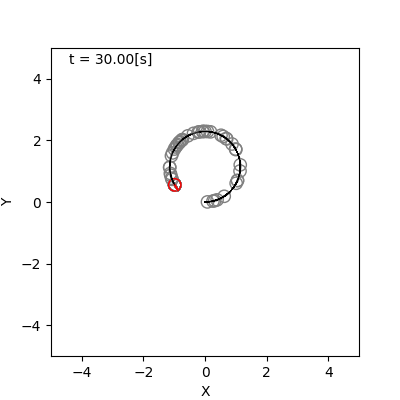

In [3]:
world = World(30, 0.1)            ###stuck_simulation###

circling = Agent(0.2, 10.0/180*math.pi)

for i in range(100):
    r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray", \
                   noise_per_meter=0, bias_rate_stds=(0.0,0.0), \
                   expected_stuck_time=60.0, expected_escape_time=60.0) 
    world.append(r)

r = IdealRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" ) 
world.append(r)

world.draw()